In [1]:
from mpu6050 import mpu6050
from matplotlib import pyplot as plt
import json
import numpy as np

In [2]:
data = None
#data/1000sampl_raw26.10.2023.13_21_10.json
#data/angles10s26.10.2023.14_32_13.json
#data/10000raw30.10.2023.14_32_10.json
with open("data/10000raw30.10.2023.14_32_10.json") as f:
    data = json.load(f)
start = data[0][0]
x = [el[0] - start for el in data]
tm = [x[i] - x[i-1] for i in range(1, len(x))]
print(f"Avg time between measurements: {sum(tm)/len(tm)}")
#bias {'a': [-0.4877683100219731, -0.04, -0.42], 'g':[4.97, 2.48857, 2.1388]}

Avg time between measurements: 0.007893168219257228


In [3]:
data[0]

[1698647530.4962363,
 {'a': {'x': 0.4333505004882812,
   'y': 0.031124621582031248,
   'z': 10.244788903808594},
  'g': {'x': -4.9465648854961835,
   'y': -2.5419847328244276,
   'z': -2.2519083969465647}}]

In [4]:
y = [el[1] for el in data]
y = [{'a': {'x': el['a']['x'] -0.4877683100219731, 'y': el['a']['y'] -0.04, 'z': el['a']['z'] -0.42},
 'g': {'x': el['g']['x'] +4.97, 'y': el['g']['y'] +2.48857, 'z': el['g']['z'] +2.1388}} for el in y]

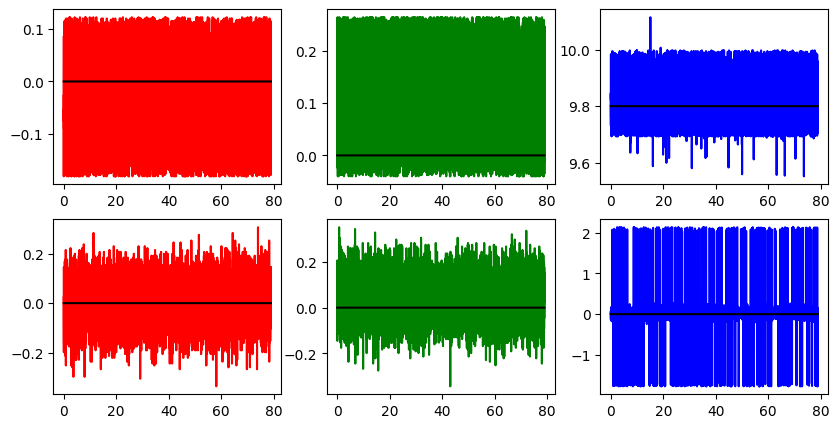

In [5]:
figure = plt.figure(figsize= (10, 5))
plt.subplot(231)
plt.plot(x, [el['a']['x'] for el in y], 'r')
plt.plot(x, [0] * len(x), 'black')
plt.subplot(232)
plt.plot(x, [el['a']['y'] for el in y], 'g')
plt.plot(x, [0] * len(x), 'black')
plt.subplot(233)
plt.plot(x, [el['a']['z'] for el in y], 'b')
plt.plot(x, [9.8] * len(x), 'black')
plt.subplot(234)
plt.plot(x, [el['g']['x'] for el in y], 'r')
plt.plot(x, [0] * len(x), 'black')
plt.subplot(235)
plt.plot(x, [el['g']['y'] for el in y], 'g')
plt.plot(x, [0] * len(x), 'black')
plt.subplot(236)
plt.plot(x, [el['g']['z'] for el in y], 'b')
plt.plot(x, [0] * len(x), 'black')
plt.show()

In [6]:
for k in ['x', 'y', 'z']:
    print(f"Avg acc for {k}: ", sum([el['a'][k] for el in y])/len(x))
    print(f"Std acc for {k}: ", np.std([el['a'][k] for el in y]), "\n")
for k in ['x', 'y', 'z']:
    print(f"Avg gyro for {k}: ", sum([el['g'][k] for el in y])/len(x))
    print(f"Std gyro for {k}: ", np.std([el['g'][k] for el in y]), "\n")

Avg acc for x:  -0.043148781159668116
Std acc for x:  0.06461329895323718 

Avg acc for y:  0.12645806752319477
Std acc for y:  0.06381657059388814 

Avg acc for z:  9.823188379998893
Std acc for z:  0.06983762746700609 

Avg gyro for x:  0.0005320610687020351
Std gyro for x:  0.08000244005587726 

Avg gyro for y:  0.044555496183206124
Std gyro for y:  0.0840545638151361 

Avg gyro for z:  0.035851145038167775
Std gyro for z:  0.3565874139444339 



In [7]:
from ahrs.filters import Madgwick as ahrsMadgwick
import numpy as np
import time
import math
def deg2rad(dat):
    return {'x': np.deg2rad(dat['x']), 'y': np.deg2rad(dat['y']), 'z': np.deg2rad(dat['z'])}
def dict2arr(dat):
    return [dat['x'], dat['y'], dat['z']]

In [29]:
madgwick = ahrsMadgwick(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = 0.007317629901019183, frequancy= 0.007317629901019183 ** (-1),
                                    gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]),
                                    acc = np.array([dict2arr(t['a']) for t in y]),
                                    gain = 0.1)

In [32]:
angles = []
for q in madgwick.Q:
    # pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
    # roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
    ww = q[0]
    xx = q[1]
    yy = q[2]
    zz = q[3]
    t0 = +2.0 * (ww * xx + yy * zz)
    t1 = +1.0 - 2.0 * (xx * xx + yy * yy)
    roll = math.atan2(t0, t1)
 
    t2 = +2.0 * (ww * yy - zz * xx)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = math.asin(t2)
    angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)})

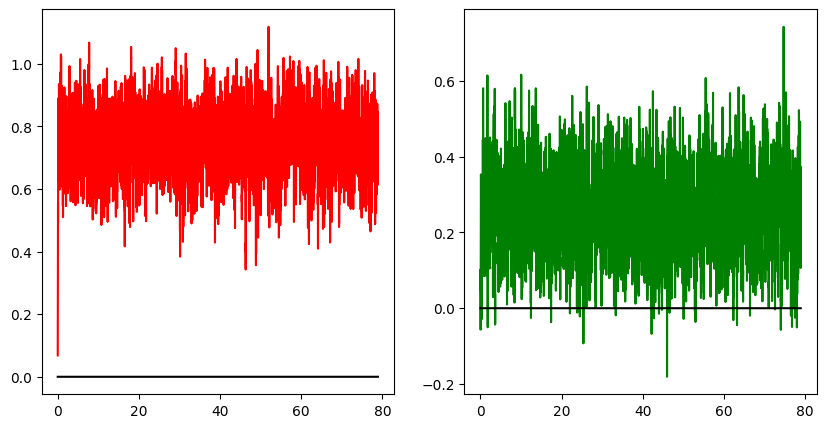

In [33]:
figure = plt.figure(figsize= (10, 5))
plt.subplot(121)
plt.plot(x, [el['roll'] for el in angles], 'r')
plt.plot(x, [0] * len(x), 'black')
plt.subplot(122)
plt.plot(x, [el['pitch'] for el in angles], 'g')
plt.plot(x, [0] * len(x), 'black')
plt.show()

In [23]:
madgwick.Q[9999]

array([0.99971049, 0.00587684, 0.00226102, 0.02322239])

In [24]:
madgwick.Q[0]

array([9.99999736e-01, 5.94692698e-04, 4.18718294e-04, 1.06404586e-06])

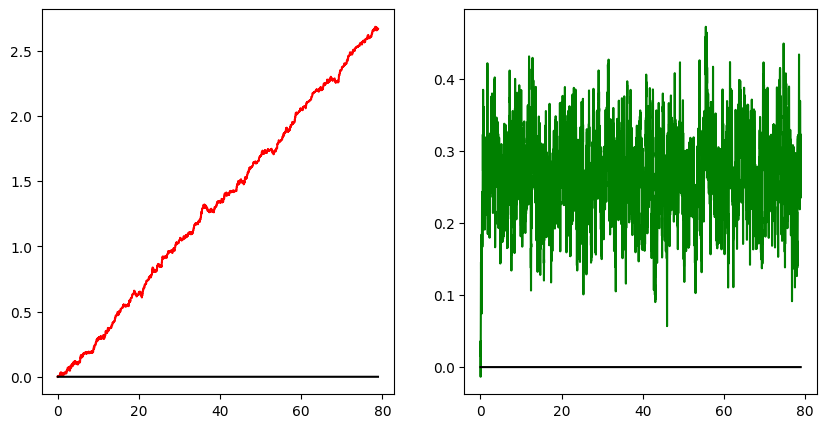

In [12]:
madgwick = ahrsMadgwick(Dt = 0.007317629901019183, frequancy= 0.007317629901019183 ** (-1))
Q = np.tile([1., 0., 0., 0.], (len(x), 1)) # Allocate for quaternions
for t in range(1, len(x)):
    # madgwick.Dt = x[t] - x[t-1]
    # madgwick.frequancy = madgwick.Dt ** (-1)
    Q[t] = madgwick.updateIMU(Q[t-1], gyr=dict2arr(deg2rad(y[t]['g'])), acc=dict2arr(y[t]['a']))

angles = []
for q in Q:
    pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
    roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
#     angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)})

# angles = []
# for q in Q:
#     pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
#     roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
#     angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)})

figure = plt.figure(figsize= (10, 5))
plt.subplot(121)
plt.plot(x, [el['roll'] for el in angles], 'r')
plt.plot(x, [0] * len(x), 'black')
plt.subplot(122)
plt.plot(x, [el['pitch'] for el in angles], 'g')
plt.plot(x, [0] * len(x), 'black')
plt.show()